# GoCa tutorial
This notebook is a tutorial and example of how to use the GoCa model to simulate and evaluate the assembly of protein complexes.

Here, we simulate the assembly of a homotrimeric protein complex, the mammalian tumor associated antigen UK114 (PDB: [1NQ3](https://www.rcsb.org/structure/1nq3)). The following figure shows the crystal structure of the protein in a cartoon representation. We will use this crystal structure as the native conformation for our simulations.
<img src="https://cdn.rcsb.org/images/structures/1nq3_assembly-1.jpeg" alt="drawing" width="250"/>

The tutorial / application example consists of five steps:
- Structure download and preparation
- Generation of the GoCa model simulation files
- Simulation with [Gromacs](https://www.gromacs.org/)
- Trajectory processing
- Simulation evaluation

#### Prerequisites:
- Gromacs (see [here](https://manual.gromacs.org/current/install-guide/index.html) for installation instructions, any newer version (>=2018) should work)
- `tleap` from AmberTools (see [here](https://ambermd.org/AmberTools.php) for installation instructions; we use this to add missing hydrogen atoms. In comparison to Amber, AmberTools is free. Alternatively, you can use any other tool to add missing hydrogen atoms to a protein structure.)
- `g++` and `make` (for building the GoCa program binary)
- `wget` for downloading files
- `python3` (for the analysis of the trajectories)
- Downloaded *GoCa* repository (where this tutorial is part of)

## 0. Program setup

The next cell contains the path to the root directory of the GoCa repository. If you move this notebook to a new location, you should add the path to the repository in the following cell. Make sure you also move the included `.mdp` files.

In [1]:
fp = '..'

Now we will download the dependencies and build the GoCa program binary. If you have already done this, you can skip this step.


(We will first save the current working directory, then switch to the GoCa repository to build the binary, and then switch back to the working directory).

In [2]:
import os
working_directory = os.getcwd()
%cd -q {fp}
!git submodule init
!git submodule update
!make
%cd -q {working_directory}

g++ -O3 -I src/include/Eigen -fopenmp -MMD -MP -c src/files.cpp -o build/files.o
g++ -O3 -I src/include/Eigen -fopenmp -MMD -MP -c src/bead.cpp -o build/bead.o
g++ -O3 -I src/include/Eigen -fopenmp -MMD -MP -c src/config.cpp -o build/config.o
g++ -O3 -I src/include/Eigen -fopenmp -MMD -MP -c src/GoCa.cpp -o build/GoCa.o
g++ -O3 -I src/include/Eigen -fopenmp -MMD -MP -c src/system.cpp -o build/system.o
g++ -O3 -I src/include/Eigen -fopenmp -MMD -MP -c src/chain.cpp -o build/chain.o
g++ -fopenmp build/files.o build/bead.o build/config.o build/GoCa.o build/system.o build/chain.o -o GoCa


We will create a new directory to store all generated files. By deleting this directory you can easily restart the tutorial. The `output-worked` directory already contains all the files we will generate during this tutorial. If you get stuck at any step, you can look there for the expected output.

In [3]:
output = 'output'
!mkdir {output}

## 1. Structure preparation
Now that everything is set up, we can start the first part of the tutorial. 

First, we download our input structure file from the PDB. Moreover, using the tool `sed`, we extract the first three chains (A, B, and C) from the `.pdb` file and remove all meta information. The original structure contains two copies of the protein trimer, therefore we want to extract only the first three chains.

In [4]:
!wget -O {output}/protein.pdb https://files.rcsb.org/download/1NQ3.pdb
!sed -i '/^ATOM.*[A-Z]\s[ABC]\s/!d' {output}/protein.pdb

--2024-01-21 22:31:01--  https://files.rcsb.org/download/1NQ3.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.157
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘output/protein.pdb’

output/protein.pdb      [   <=>              ] 524,76K   994KB/s    in 0,5s    

2024-01-21 22:31:02 (994 KB/s) - ‘output/protein.pdb’ saved [537354]



The first two chains are missing a serine amino acid at the beginning, while the third chain is missing an alanine at the end. For topology merging, we want all chains to have the same sequence. Therefore, for simplicity, we just remove the last amino acid from the first two chains and the first residue from the third chain.

In [5]:
!sed -i '/ALA A 135/d' {output}/protein.pdb
!sed -i '/ALA B 135/d' {output}/protein.pdb
!sed -i '/SER C   2/d' {output}/protein.pdb

The downloaded structure file does not contain hydrogen atoms. Since the *GoCa* programs assume that input structures contain hydrogens by default, we add hydrogens using the `hydrogenize.sh` script. This script is part of the *GoCa* repository and uses the `tleap` program from the AmberTools package.

In [6]:
!./{fp}/hydrogenize.sh {output}/protein.pdb {output}/protein-h.pdb {output}/tleap.log
!rm leap.log

The protein structure is now ready to be processed by the *GoCa* program.

## 2. Generation of the CoCa model simulation files
Before running the *GoCa* program, we can change various configuration parameters. However, the default configuration is a good start and sufficient for our example. We will use the configuration file included in the tutorial directory.  
After the configuration file is prepared, we can finally run the *GoCa* program to generate the coarse-grained topology and coordinate file:

In [7]:
!./{fp}/GoCa GoCa-config.ini

1. Generating coarse grained model
Info: Reading protein file: output/protein-h.pdb
Info: Got a total of 396 Cα-atoms from 5916 atoms in 3 chain(s)
2. Calculating native contacts
Info: Got 1 merged chain from originally 3 chains
Chain 1: SLVRRIISTAKAPAAIGPYSQAVLVDRTIYISGQLGMDPASGQLVPGGVVEEAKQALTNIGEILKAAGCDFTNVVKATVLLADINDFSAVNDVYKQYFQSSFPARAAYQVAALPKGGRVEIEAIAVQGPLTT
Chain 2: SLVRRIISTAKAPAAIGPYSQAVLVDRTIYISGQLGMDPASGQLVPGGVVEEAKQALTNIGEILKAAGCDFTNVVKATVLLADINDFSAVNDVYKQYFQSSFPARAAYQVAALPKGGRVEIEAIAVQGPLTT
Chain 3: SLVRRIISTAKAPAAIGPYSQAVLVDRTIYISGQLGMDPASGQLVPGGVVEEAKQALTNIGEILKAAGCDFTNVVKATVLLADINDFSAVNDVYKQYFQSSFPARAAYQVAALPKGGRVEIEAIAVQGPLTT
3. Writing topology file to output/output.top
4. Writing coordinate file to output/output.gro


The output directory contains a `.top` and a `.gro` file now.  
The topology file describes the interactions within our protein complex based on the native conformation we provided. We can use this custom force field for our simulation.  
The coordinate file also contains the native conformation. However, we don't want our simulation to start with the assembled structure. Instead, we want to start with a disassembled configuration and simulate the assembly process. Therefore, we use a coordinate file with randomly placed homomeric protein subunits. To generate such a configuration, we first extract a single chain from the coordinate file (using the residue index of each coarse-grained bead):

In [8]:
with open(f'{output}/output-single.gro', 'w') as output_file:
    with open(f'{output}/output.gro', 'r') as input_file:
        lines = input_file.readlines()
        lines = [line for i, line in enumerate(lines) if i < 2 or i > len(lines) - 2 or int(line[:5]) == i - 1]
        lines[1] = f'{len(lines) - 3}\n'
        output_file.write(''.join(lines))

We use the GROMACS command `gmx insert-molecules` to generate the random configuration with three subunits and the same box size as in our assembled coarse-grained structure file:

In [9]:
box_size = ' '.join(lines[-1].split())
!gmx insert-molecules -ci {output}/output-single.gro -o {output}/random.gro -box {box_size} -nmol 3 -try 100

                  :-) GROMACS - gmx insert-molecules, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/GoCa/tutorial
Command line:
  gmx insert-molecules -ci output/output-single.gro -o output/random.gro -box 11.24990 10.96070 11.39100 -nmol 3 -try 100

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From version 5.0 gmx insert-molecules uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLL

Now, everything is prepared to start the Gromacs simulation.

## 3. Simulation

Since we have randomly placed the protein subunits in the simulation box, it is safer to do an energy minimization first. Then we run the assembly simulation. This may take a few minutes, depending on your hardware.

In [10]:
!gmx grompp -f minimization.mdp -p {output}/output.top -c {output}/random.gro -o {output}/minimization.tpr -po {output}/minimization.mdp
!gmx mdrun -deffnm {output}/minimization

                       :-) GROMACS - gmx grompp, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/GoCa/tutorial
Command line:
  gmx grompp -f minimization.mdp -p output/output.top -c output/random.gro -o output/minimization.tpr -po output/minimization.mdp

Setting the LD random seed to 1060793585

Generated 1113 of the 1176 non-bonded parameter combinations

Excluding 3 bonded neighbours molecule type 'Molecule0'
Analysing residue names:
There are:   396    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group rest is 1185.00

This run will generate roughly 0 Mb of data

GROMACS reminds you: "I originally implemented PME to prove that you didn't need it..." (Erik Lindahl)

                       :-) GROMACS - gmx mdrun, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/GoCa/tutorial
Command line:
  gmx mdrun -deffnm output/minimization

Reading f

In [11]:
!gmx grompp -f simulation.mdp -p {output}/output.top -c {output}/minimization.gro -o {output}/simulation.tpr -po {output}/simulation.mdp
!gmx mdrun -deffnm {output}/simulation

                       :-) GROMACS - gmx grompp, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/GoCa/tutorial
Command line:
  gmx grompp -f simulation.mdp -p output/output.top -c output/minimization.gro -o output/simulation.tpr -po output/simulation.mdp

Setting the LD random seed to 2113621878

Generated 1113 of the 1176 non-bonded parameter combinations

Excluding 3 bonded neighbours molecule type 'Molecule0'

turning all bonds into constraints...

Setting gen_seed to -1814110357

Velocities were taken from a Maxwell distribution at 40 K
Analysing residue names:
There are:   396    Protein residues
Analysing Protein...
Number of degrees of freedom in T-Coupling group System is 792.00

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 35 K

Calculated rlist for 1x1 atom pair-list as 4.000 nm, buffer size 0.000 nm

Set rlist, assuming 4x4 atom pair-list, to 4.000 nm, buffer size 0.000 nm

Note that mdrun will redete

After the simulation finished, we can continue with the processing of the trajectories.

## 4. Processing
For the simulation we use periodic boundaries. Because these can make the analysis complicated, we use the Gromacs tool `gmx trjconv` with the option `-pbc cluster`. As a result, we obtain a trajectory which allows to observe the assembly of the protein complex.

In [12]:
!echo -e '0\n0\n0\n' | \
gmx trjconv -f {output}/simulation.xtc -s {output}/simulation.tpr -o {output}/simulationNoPBC.xtc -center -pbc cluster

                      :-) GROMACS - gmx trjconv, 2022 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/GoCa/tutorial
Command line:
  gmx trjconv -f output/simulation.xtc -s output/simulation.tpr -o output/simulationNoPBC.xtc -center -pbc cluster

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file output/simulation.tpr, VERSION 2022 (single precision)
Reading file output/simulation.tpr, VERSION 2022 (single precision)
Select group for clustering
Group     0 (         System) has   396 elements
Group     1 (        Protein) has   396 elements
Group     2 (      Protein-H) has   396 elements
Group     3 (        C-alpha) has   396 elements
Group     4 (       Backbone) has   396 elements
Group     5 (      MainChain) has   396 elements
Group     6 (   MainChain+Cb) has   396 elements
Group     7 (    MainChain+H) has   39

Due to the `-pbc cluster` option, jumps of individual, unassembled chains may occur between trajectory frames. However, this option ensures that already assembled parts of the protein complex are never separated by the periodic boundary conditions. Since we are more interested in the assembly of the complex than in the trajectories of the individual chains, this is not a problem.

## 5. Evaluation

In the last part of this tutorial we will continue with the analysis of our simulation.  
We will use some Python functions provided with the *GoCa* repository to extract different properties from the simulation trajectory.  
We start by importing some Python packages:

In [13]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(f'{fp}/evaluation')
import analysis as goca_analysis
import gromacs_analysis as goca_gmx_analysis

We load the processed trajectory, together with the coarse-grained topology and the structure of the native conformation into a `goca_gmx_analysis.GromacsTrajectory` object, which inherits from the `goca_analysis.Trajectory` class.

In [14]:
trajectory = goca_gmx_analysis.GromacsTrajectory(
    f'{output}/simulationNoPBC.xtc',
    f'{output}/output.gro',
    f'{output}/output.top'
)

#### RMSD
We start with the analysis of the [RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions) of the individual chains and of the entire complex. We iterate over all frames in the trajectory and calculate the RMSD from the native conformation:

In [15]:
chains_indices = [trajectory.get_chain_start_stop_indices(i) for i in range(3)] # Individual chains
chains_indices += [(0, trajectory.size())] # Complete complex
rmsd = np.empty((len(trajectory.get_trajectory()), len(chains_indices)))
for i, frame in enumerate(trajectory.get_trajectory()):
    rmsd[i] = [
        goca_analysis.aligned_rmsd(
            frame[cids[0]:cids[1]],
            trajectory.get_initial_conformation()[cids[0]:cids[1]]
        ) for cids in chains_indices
    ]

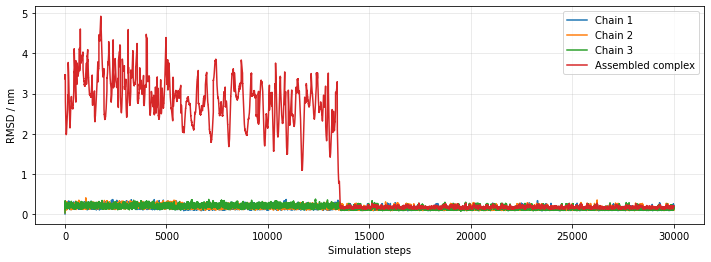

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(rmsd)
plt.legend(['Chain 1', 'Chain 2', 'Chain 3', 'Assembled complex'])
plt.ylabel('RMSD / nm')
plt.xlabel('Simulation steps')
plt.grid(alpha=0.3)
plt.show()

Since we start with a configuration of folded but disassembled chains, the RMSD of each chain is close to zero at the beginning of the trajectory. Furthermore, the RMSDs of the chains remain close to zero, i.e. they remain folded throughout the simulations. In contrast, the RMSD of the entire complex is not close to zero at the beginning of the simulation. However, after about 13000 simulation steps, the RMSD of the protein complex also drops to a value close to zero. This indicates successful assembly of the complex.

#### Fraction of native contacts
Furthermore, we can analyze the fraction of native contacts within and between the protein chains. Here, native contacts correspond to all native pairs in the topology file as derived from the native conformation. A logistic sigmoid cutoff is used to determine whether two coarse-grained beads form a native contact or not.

In [17]:
fnc_intramolecular = trajectory.get_fraction_of_native_contacts_inside()
fnc_intermolecular = trajectory.get_fraction_of_native_contacts_between()

We plot both fraction of native contact evaluations in the same diagram. Since the topology contains intermolecular native pairs between all possible chain pair combinations and the final assembly contains only three chain pair contacts, we must multiply the intermolecular fraction of native contacts by a factor of three:

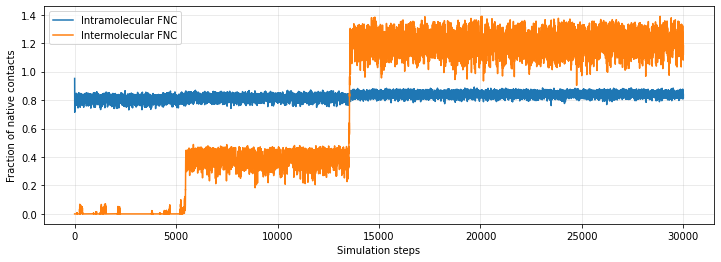

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(fnc_intramolecular, label="Intramolecular FNC")
plt.plot(fnc_intermolecular * 3, label="Intermolecular FNC")
plt.ylabel('Fraction of native contacts')
plt.xlabel('Simulation steps')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

This graph complements the findings of the previous graph. The intramolecular FNC remains relatively constant throughout the trajectory (except for small fluctuations). In contrast, the intermolecular FNC starts at about zero. After about 5500 simulation steps, it suddenly increases and then remains relatively constant at that level for about 7500 simulation steps. Finally, it increases again and remains at this level (again with some fluctuations) until the end of the simulation. The intermolecular FNC indicates the two assembly steps of our trimeric protein complex: first, two subunits assemble into a dimer. Second, the dimer binds to the last free chain to form the final trimeric structure.

#### Assembly state clustering
Finally, we can cluster all the trajectory frames into different assembly states. First, we transform each trajectory frame into a graph object. The nodes of the graph objects correspond to the chains of the protein complex. If two chains are bound, their nodes are connected by an edge. Afterwards, these graphs are used for the clustering of the assembly path.

In [19]:
graphs = trajectory.get_chain_graph(logging=False)
clusters, labels = trajectory.get_chain_formations(graphs, filtering=100)

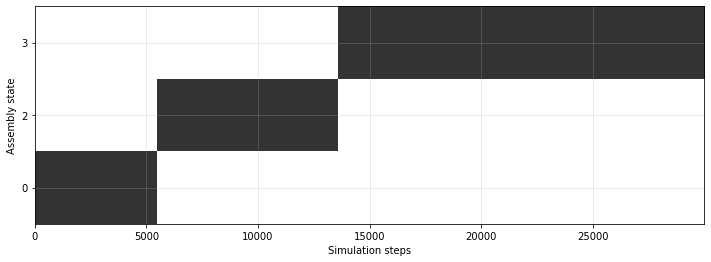

In [20]:
plt.figure(figsize=(12, 4))
plt.imshow(clusters, interpolation='nearest', aspect='auto', cmap='Greys', alpha = 0.8)
plt.yticks(np.arange(0, len(labels)), labels)
plt.ylabel('Assembly state')
plt.xlabel('Simulation steps')
plt.grid(alpha=0.3)
plt.show()

This diagram shows, similar to the previous plot, the assembly path of the three protein chains. In the beginning, all chains are unbound (state 0). After approximately 5500 simulation steps, two chains form a dimer (state 2). After another 7500 steps, the trimeric complex is formed (state 3).